C:\Users\sunfr\AppData\Local\Temp\ipykernel_32912\2311801597.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio = read("input2.wav")


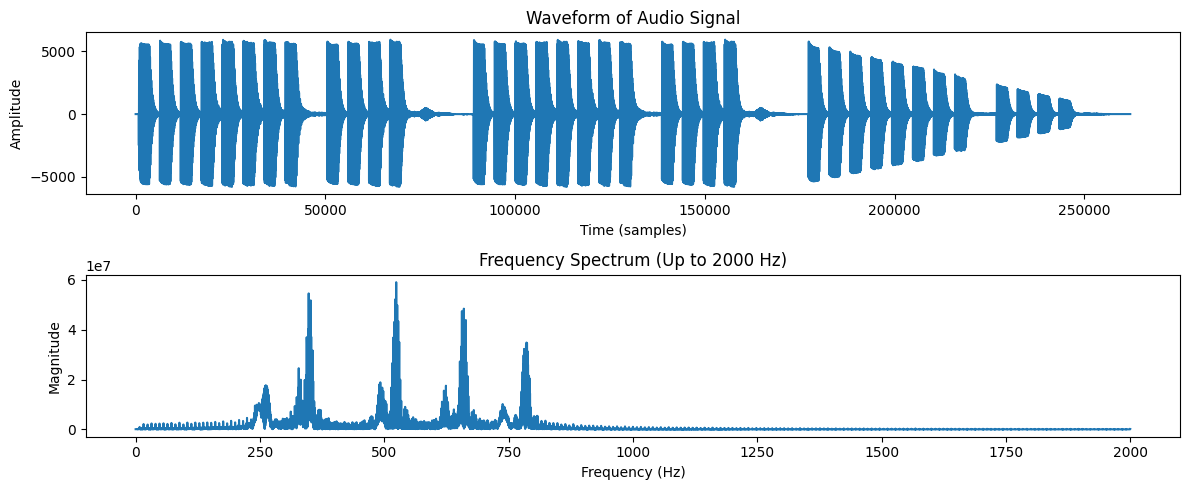

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from scipy.fftpack import fft

sample_rate, audio = read("input2.wav")

# Convert to mono if stereo
if len(audio.shape) > 1:
    audio = audio[:, 0]

N = len(audio)
audio_segment = audio[:N]

fft_result = fft(audio_segment)
frequencies = np.fft.fftfreq(N, d=1/sample_rate)

plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(audio_segment)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Waveform of Audio Signal")

max_freq = 2000
indices = np.where(frequencies >= 0)[0]  
indices = indices[frequencies[indices] <= max_freq]  

plt.subplot(2, 1, 2)
plt.plot(frequencies[indices], np.abs(fft_result[indices]))  
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Spectrum (Up to 2000 Hz)")
plt.tight_layout()
plt.show()
